<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/chronoroot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChronoRoot　（未完）
訓練済みのモデルで根の解析を行うノートブック

## ライセンス
- ChronoRoot論文, Gaggion et al., 2021, GigaScience (https://academic.oup.com/gigascience/article/10/7/giab052/6324285)
    - CC-BY
- 公式レポジトリ (https://github.com/ngaggion/ChronoRoot)
    - GPLv3
- データセット (http://gigadb.org/dataset/100911)
    - GIGAdbの利用規約が定めるライセンス（http://gigadb.org/site/term; CC0相当）に準拠
- 本稿プログラムコード
    - **本章のコードは公式レポジトリのライセンスを継承してGPLv3となります。**

### メモ
python segmentFast.py imagePath --output_dir optionalSegPath --use_crf boolean --model ResUNetDS
- > 結果をchronorootで解析


## 環境構築

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
!cp /content/drive/MyDrive/phenotyping_temp_assets/Test_ChronoRoot.zip ./
!unzip Test_ChronoRoot.zip  > /dev/null 2>&1

In [3]:
!cp /content/drive/MyDrive/phenotyping_temp_assets/chronoroot/cr_resunetds.onnx ./
!cp /content/drive/MyDrive/phenotyping_temp_assets/chronoroot/ChronoRootEnsemble.onnx ./

In [4]:
# 公式レポジトリのクローニング
!git clone https://github.com/ngaggion/ChronoRoot.git

# pydensecrfのインストール
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git  > /dev/null 2>&1
!pip install onnx onnxruntime-gpu > /dev/null 2>&1
# モデルチェックポイントファイルのダウンロード
# !gdown 1OSqvRXKay-0bsmQqtlmYnu_sp6-_I-eC
# !unzip modelWeights.zip

# テストデータセットのダウンロード
# !wget -O Test_ChronoRoot.zip https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100911/LabeledDataset/Test_ChronoRoot.zip
# !unzip Test_ChronoRoot.zip

# 不要ファイルの削除
# !rm modelWeights.zip
# !rm Test_ChronoRoot.zip

Cloning into 'ChronoRoot'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 108 (delta 57), reused 88 (delta 39), pack-reused 0
Receiving objects: 100% (108/108), 925.53 KiB | 31.91 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [5]:
#https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=kDn_lVxg3Z2G
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!apt-get install libzbar0 &>/dev/null
!pip install pyzbar &>/dev/null

Executing: /tmp/apt-key-gpghome.O1mNXXdAAk/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [44.8 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,131 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:8 http://downloads.skewed.de/apt jammy InRelease [7,536 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:10 https://ppa.launchpadcontent.net/c2d4u.team

5
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)


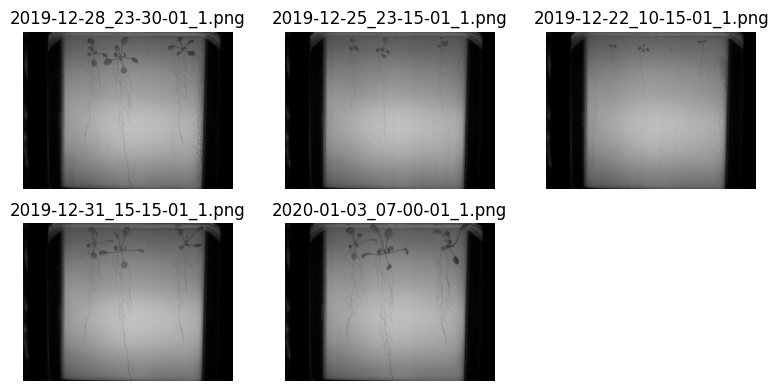

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

# nii.gzはアノテーションファイルであるため、png拡張子の画像のみフィルタリングする
files = [x for x in os.listdir(TEST_DIR) if x.endswith(".png")]
print(len(files))  # 5枚

plt.figure(figsize=(8,4))
for i, file in enumerate(files):
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path)
    print(image.shape)
    image = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    plt.subplot(2,3,i+1)
    plt.title(file)
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()

In [7]:
# 作者らの公式レポジトリのREADMEに従い、colaboratoryでsegmentFastやsegmentEnsembleを実行すると
# tensorflowのバージョン齟齬によりエラーがおきます。独自の環境で実行したい方は公式推奨のdockerイメージを利用してください。

In [8]:
import onnxruntime as ort

In [9]:
# classifier_path = "/content/ChronoRootEnsemble.onnx"
# providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
# ort_session = ort.InferenceSession(classifier_path, providers=providers)

# # inputとoutputの名前を把握します。
# input_names = [input.name for input in ort_session.get_inputs()]
# output_names = [output.name for output in ort_session.get_outputs()]

# print("Input names:", input_names)
# print("Output names:", output_names)

In [10]:
import pydensecrf.densecrf as dcrf

def post_process(prediction):
    accum = np.zeros(prediction.shape[1:3])
    image = cv2.cvtColor((prediction[0,:,:,0]*255).astype('uint8'), cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(prediction[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)

    accum = 0.8 * accum + crf_map[:,:,1]
    return accum

def pad_image_to_multiple_of(v, multipleOf=[8, 8], mode='symmetric'):
    padding = ((0, 0 if v.shape[0] % multipleOf[0] == 0 else multipleOf[0] - (v.shape[0] % multipleOf[0])),
               (0, 0 if v.shape[1] % multipleOf[1] == 0 else multipleOf[1] - (v.shape[1] % multipleOf[1])))
    return np.pad(v, padding, mode)

def preprocess(image):
    # assure dtype is float32
    image = image.astype(np.float32)/255.
    # 画像サイズが32の倍数になるようにpaddingします。
    image = pad_image_to_multiple_of(image, [32,32])
    image = image[np.newaxis, ..., np.newaxis]
    return image


In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import gc
import onnxruntime as ort

In [12]:
import time

In [13]:
import tempfile

## resunetds single

In [18]:
def single_crf(image, mask, accum):
    image *= 255.
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(mask[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)
    accum = 0.8 * accum + crf_map[:,:,1]
    return accum

model = "ResUNetDS"
classifier_path = os.path.join("/content/drive/MyDrive/phenotyping_temp_assets/chronoroot/",model+".onnx")
providers = ['CUDAExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

for i, file in enumerate(files):
    print(file)
    path = os.path.join(TEST_DIR, file)
    orig_image = cv2.imread(path, 0 )
    image = orig_image.copy()
    # image = preprocess(image)
    image = image.astype(np.float32)/255.
    # 画像サイズが32の倍数になるようにpaddingします。
    image = pad_image_to_multiple_of(image, [32,32])
    # create accumulation template for crf
    if i == 0:
        accum = np.zeros_like(image)

    inputs = image[np.newaxis, ..., np.newaxis]
    predictions = ort_session.run(output_names, {input_names[0]: inputs})[0]
    accum = single_crf(image, predictions, accum)
    _, output = cv2.threshold(accum, 0.5, 1.0, cv2.THRESH_BINARY)
    # np.save(os.path.join(temp_dir, model+file+".npy"), output)
    cv2.imwrite(os.path.join(temp_dir,model+file), output*255)

# メモリ解放
del ort_session
gc.collect()

2019-12-22_10-15-01_1.png
2019-12-25_23-15-01_1.png
2019-12-28_23-30-01_1.png
2019-12-31_15-15-01_1.png
2020-01-03_07-00-01_1.png


0

In [82]:
# chronorootanalyzerの中のgetroiandseedの中のselectROIがcv2.selectroiでgui window依存。最初から切り抜いてここを迂回するスクリプトを組む必要あり。

import os
import csv
import cv2
import numpy as np
import json
from skimage.morphology import skeletonize

from ChronoRoot.graph.fileFunc import createResultFolder, loadPath  #, getROIandSeed
from ChronoRoot.graph.imageFunc import getCleanSeg, getCleanSke, savePlotImages, saveEmpty, plot_graph
from ChronoRoot.graph.graphFunc import createGraph, saveGraph, saveProps
from ChronoRoot.graph.trackFunc import graphInit, matchGraphs
from ChronoRoot.graph.rsmlFunc import createTree
from ChronoRoot.graph.graphPostProcess import trimGraph
from ChronoRoot.graph.dataWork import dataWork

In [ ]:
mask_dir = "/content/masks"
# 日付が最も新しい写真を選ぶ
# newest_file = sorted(os.listdir(mask_dir))[-1]

image = cv2.imread("/content/temp/ResUNetDS2020-01-03_07-00-01_1.png")

# 今回は手動でbboxを設定する
bboxes = [
    [876,348,876+410,348+1516],
    [1364,434,1364+460,434+2030],
    [2312,372,2312+378,372+1554]
]
seeds = [
    [1036,384],
    [1482,436],
    [2428,384]
]
print(bboxes)
for bbox in bboxes:
    image = cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,255,0), 2)
for seed in seeds:
    image = cv2.circle(image, (seed[0],seed[1]), 50, (0,255,0), -1)
plt.imshow(image)

1


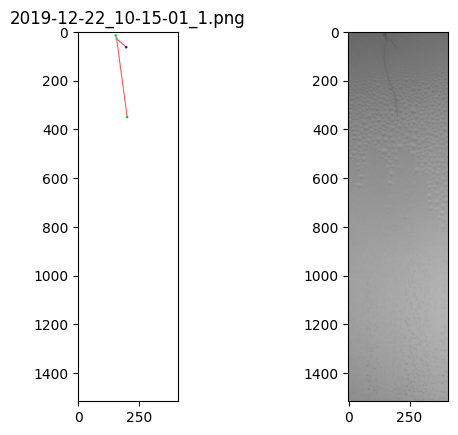

2


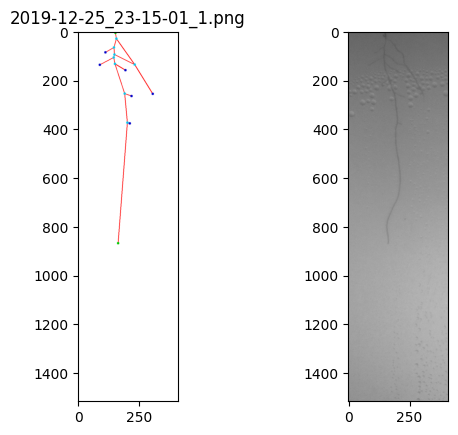

4


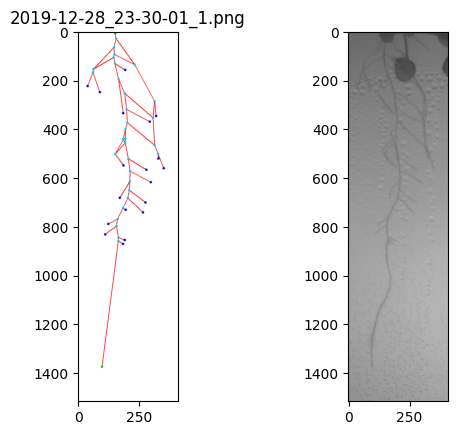

2


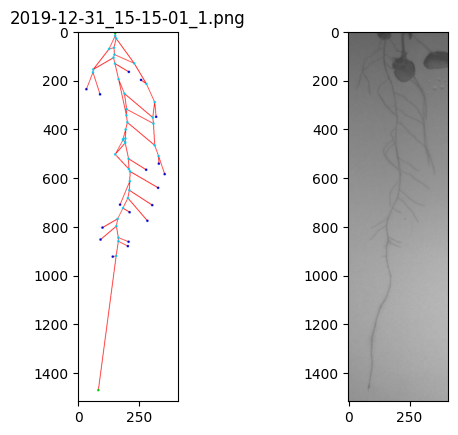

2


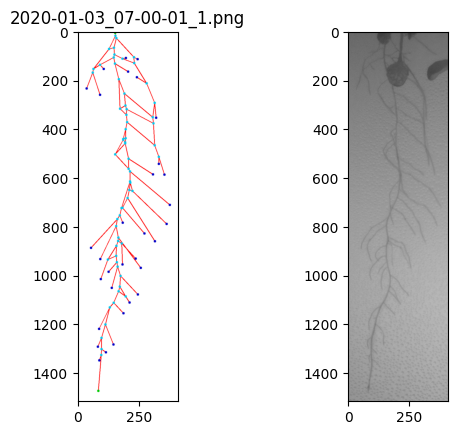

In [105]:
def assure_bbox_safe_coord(seed,bbox):
    # seedがbboxより外にあったときのことを考え、補正する
    seed[0] = np.max([bbox[0],seed[0]])
    seed[0] = np.min([bbox[2],seed[0]]) - bbox[0]
    seed[1] = np.max([bbox[1],seed[1]])
    seed[1] = np.min([bbox[3],seed[1]]) - bbox[1]
    seed = [x.astype(np.uint16) for x in seed]
    return seed

def get_crop_from_segmentation(mask, bbox, seed):
    # https://github.com/ngaggion/ChronoRoot/blob/master/graph/imageFunc.pyより改変
    # seedより上を黒く塗りつぶす
    # mask[0:seed[1], :] = 0
    # bboxに基づいてクロップする
    seg = mask[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    seg[0: seed[1],:] = 0
    return seg

def clean_segmentation(seg):
    kernel_size = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_size,kernel_size))
    seg = cv2.dilate(seg, kernel)
    seg = cv2.erode(seg, kernel)
    seg = cv2.erode(seg, kernel)
    seg = cv2.dilate(seg, kernel)
    return seg

def filter_segmentation(seg, seed):
    contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    print(len(contour_sizes))
    if len(contour_sizes) != 0:
        ### Sorts list of contours by size from bigger to smaller
        contour_sizes.sort(key=lambda x: x[0], reverse=True)
        for contour in contour_sizes:
            if contour[0] < 30:
                break
            else:
                dist = cv2.pointPolygonTest(contour[1],(seed[0], seed[1]), True)
                dist = np.abs(dist)
                is_in = cv2.pointPolygonTest(contour[1],(seed[0], seed[1]), False) > 0

                if (dist < 30 or is_in):
                    mask = np.zeros(seg.shape, np.uint8)
                    cv2.drawContours(mask,[contour[1]], -1, 255, -1)
                    seg2 = cv2.bitwise_and(mask, seg.copy())

                    return seg2, True

    return seg, False

def graph_reconstruction(image_dir, mask_dir, bboxes, seeds):
    # bboxesとseedsのlength, 対応オブジェクトの順番は揃えること

    image_files = [file for file in sorted(os.listdir(image_dir)) if file.endswith("png")]
    mask_files = [file for file in sorted(os.listdir(mask_dir)) if file.endswith("png")]

    results = []
    for i,(bbox,seed) in enumerate(zip(bboxes, seeds)):
        results["id"] = i
        original_seed = assure_bbox_safe_coord(seed,bbox)
        results["id"]["original_seed"] = original_seed
        results["id"]["bbox"] = bbox
        for image_file, mask_file in zip(image_files, mask_files):
            image = cv2.imread(os.path.join(image_dir, image_file))
            mask = cv2.imread(os.path.join(mask_dir, mask_file), 0)

            seg = get_crop_from_segmentation(mask, bbox, original_seed)
            seg = clean_segmentation(seg)
            seg, seg_presence = filter_segmentation(seg, original_seed)

            if seg_presence:
                ske, bnodes, enodes, flag = getCleanSke(seg)
                # if flag:
                #     start = i
                #     break
                grafo, seed, ske2 = createGraph(ske.copy(), original_seed, enodes, bnodes)
                grafo, ske, ske2 = trimGraph(grafo, ske, ske2)
                grafo = graphInit(grafo)
                #saveGraph(grafo, gPath)
                #print(grafo)
                # confがないため再実装する
                # rsmlTree, numberLR = createTree(conf, i, images, grafo, ske, ske2)
                # フォルダが自動生成されないっぽい
                # savePlotImages(str(i).zfill(2)+image_file,
                #                "./",
                #                image[bbox[1]:bbox[3],bbox[0]:bbox[2],:],
                #                seg, grafo, ske2)
                grafo_img = plot_graph(grafo, image[bbox[1]:bbox[3],bbox[0]:bbox[2],:].shape)
                plt.subplot(1,2,1)
                plt.title(image_file)
                plt.imshow(grafo_img)
                plt.subplot(1,2,2)
                plt.imshow(image[bbox[1]:bbox[3],bbox[0]:bbox[2],:])
                plt.show()
        break

    return

image_dir = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"
mask_dir = "/content/temp"

bboxes = [
    [876,348,876+410,348+1516],
    [1364,434,1364+460,434+2030],
    [2312,372,2312+378,372+1554]
]
seeds = [
    [1036,354],
    [1482,406],
    [2428,354]
]

graph_reconstruction(image_dir, mask_dir, bboxes, seeds)

## ensemble

In [14]:
def single_crf(image, mask):
    image *= 255.
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(mask[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)
    outimg = crf_map[:,:,1]
    return outimg

TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"
files = sorted([x for x in os.listdir(TEST_DIR) if x.endswith(".png")])
# SegNetはGPUメモリが足りないため使用しない。
!mkdir temp
temp_dir = "temp"
# with tempfile.TemporaryDirectory() as temp_dir:
for model in ["DeepLab", "UNet", "ResUNet","ResUNetDS"]:
    print(model)
    classifier_path = os.path.join("/content/drive/MyDrive/phenotyping_temp_assets/chronoroot/",model+".onnx")
    providers = ['CUDAExecutionProvider']
    ort_session = ort.InferenceSession(classifier_path, providers=providers)
    input_names = [input.name for input in ort_session.get_inputs()]
    output_names = [output.name for output in ort_session.get_outputs()]

    # メモリ不足に備え、一時ファイルに保存し、メモリを開放してからaggregateする
    for file in files:
        print(file)
        path = os.path.join(TEST_DIR, file)
        orig_image = cv2.imread(path, 0 )
        image = orig_image.copy()
        # image = preprocess(image)
        image = image.astype(np.float32)/255.
        # 画像サイズが32の倍数になるようにpaddingします。
        image = pad_image_to_multiple_of(image, [32,32])
        inputs = image[np.newaxis, ..., np.newaxis]

        predictions = ort_session.run(output_names, {input_names[0]: inputs})[0]
        output = single_crf(image, predictions)
        # np.save(os.path.join(temp_dir, model+file+".npy"), output)
        cv2.imwrite(os.path.join(temp_dir,model+file), output*255)
    # メモリ解放
    del ort_session
    gc.collect()

DeepLab
2019-12-22_10-15-01_1.png
2019-12-25_23-15-01_1.png
2019-12-28_23-30-01_1.png
2019-12-31_15-15-01_1.png
2020-01-03_07-00-01_1.png
UNet
2019-12-22_10-15-01_1.png
2019-12-25_23-15-01_1.png
2019-12-28_23-30-01_1.png
2019-12-31_15-15-01_1.png
2020-01-03_07-00-01_1.png
ResUNet
2019-12-22_10-15-01_1.png
2019-12-25_23-15-01_1.png
2019-12-28_23-30-01_1.png
2019-12-31_15-15-01_1.png
2020-01-03_07-00-01_1.png
ResUNetDS
2019-12-22_10-15-01_1.png
2019-12-25_23-15-01_1.png
2019-12-28_23-30-01_1.png
2019-12-31_15-15-01_1.png
2020-01-03_07-00-01_1.png


In [ ]:
# アンサンブル結果統合
!mkdir masks

for file in files:
    target_files = [x for x in os.listdir(temp_dir) if x.endswith(file)]
    masks = []
    print(target_files)
    for target_file in target_files:
        mask = cv2.imread(os.path.join(temp_dir, target_file), 0) /255.
        masks.append(mask)

    ensemble = np.zeros_like(masks[0])
    for mask in masks:
        ensemble += mask
    ensemble /= len(masks)
    _, ensemble = cv2.threshold(ensemble, 0.5, 1.0, cv2.THRESH_BINARY)
    ensemble = ensemble.astype(np.uint8)
    ensemble *= 255
    cv2.imwrite(os.path.join("masks", file), ensemble)

['DeepLab2019-12-22_10-15-01_1.png', 'UNet2019-12-22_10-15-01_1.png', 'ResUNet2019-12-22_10-15-01_1.png', 'ResUNetDS2019-12-22_10-15-01_1.png']
['ResUNet2019-12-25_23-15-01_1.png', 'DeepLab2019-12-25_23-15-01_1.png', 'ResUNetDS2019-12-25_23-15-01_1.png', 'UNet2019-12-25_23-15-01_1.png']
['ResUNetDS2019-12-28_23-30-01_1.png', 'ResUNet2019-12-28_23-30-01_1.png', 'UNet2019-12-28_23-30-01_1.png', 'DeepLab2019-12-28_23-30-01_1.png']
['ResUNetDS2019-12-31_15-15-01_1.png', 'ResUNet2019-12-31_15-15-01_1.png', 'UNet2019-12-31_15-15-01_1.png', 'DeepLab2019-12-31_15-15-01_1.png']
['DeepLab2020-01-03_07-00-01_1.png', 'ResUNet2020-01-03_07-00-01_1.png', 'UNet2020-01-03_07-00-01_1.png', 'ResUNetDS2020-01-03_07-00-01_1.png']


In [ ]:
# chronorootanalyzerの中のgetroiandseedの中のselectROIがcv2.selectroiでgui window依存。最初から切り抜いてここを迂回するスクリプトを組む必要あり。

import os
import csv
import cv2
import numpy as np
import json

from ChronoRoot.graph.fileFunc import createResultFolder, loadPath  #, getROIandSeed
from ChronoRoot.graph.imageFunc import getCleanSeg, getCleanSke, savePlotImages, saveEmpty
from ChronoRoot.graph.graphFunc import createGraph, saveGraph, saveProps
from ChronoRoot.graph.trackFunc import graphInit, matchGraphs
from ChronoRoot.graph.rsmlFunc import createTree
from ChronoRoot.graph.graphPostProcess import trimGraph
from ChronoRoot.graph.dataWork import dataWork

[[844, 300, 1294, 1882], [1348, 360, 1836, 2464], [2270, 366, 2728, 1966]]


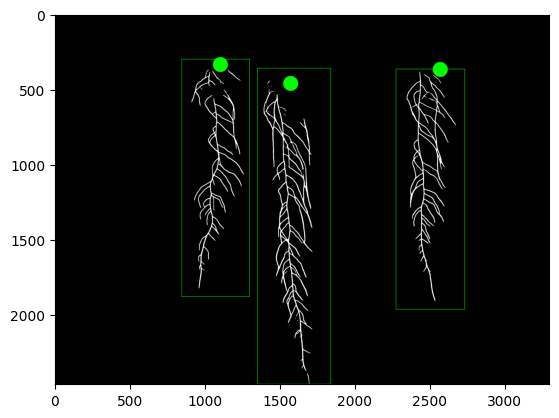

In [ ]:
mask_dir = "/content/masks"
# 日付が最も新しい写真を選ぶ
# newest_file = sorted(os.listdir(mask_dir))[-1]

image = cv2.imread("/content/masks/2020-01-03_07-00-01_1.png")

# 今回は手動でbboxを設定する
bboxes = [
    [844,300,844+450,300+1582],
    [1348,360,1348+488,360+2104],
    [2270,366,2270+458,366+1600]
]
seeds = [
    [1101,336],
    [1569,462],
    [2565,369]
]
print(bboxes)
for bbox in bboxes:
    image = cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,255,0), 2)
for seed in seeds:
    image = cv2.circle(image, (seed[0],seed[1]), 50, (0,255,0), -1)
plt.imshow(image)

In [ ]:
def get_crop_from_segmentation(mask, bbox, seed):
    # https://github.com/ngaggion/ChronoRoot/blob/master/graph/imageFunc.pyより改変
    # seedがbboxより外にあったときのことを考え、補正する
    seed[0] = np.max([bbox[0],seed[0]])
    seed[0] = np.min([bbox[2],seed[0]])
    seed[1] = np.max([bbox[1],seed[1]])
    seed[1] = np.min([bbox[3],seed[1]])
    seed  =[x.astype(np.uint8) for x in seed]

    # seedより上を黒く塗りつぶす
    # mask[0:seed[1], :] = 0
    # bboxに基づいてクロップする
    seg = mask[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    seg[0: seed[1],:] = 0
    # plt.imshow(seg)
    # plt.show()
    kernel_size = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_size,kernel_size))
    seg = cv2.dilate(seg, kernel)
    seg = cv2.erode(seg, kernel)
    seg = cv2.erode(seg, kernel)
    seg = cv2.dilate(seg, kernel)
    contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]

    if len(contour_sizes) != 0:
        ### Sorts list of contours by size from bigger to smaller
        contour_sizes.sort(key=lambda x: x[0], reverse=True)
        for contour in contour_sizes:
            print(contour[0])
            if contour[0] < 30:
                break
            else:
                dist = cv2.pointPolygonTest(contour[1],(seed[0], seed[1]), True)
                dist = np.abs(dist)
                is_in = cv2.pointPolygonTest(contour[1],(seed[0], seed[1]), False) > 0
                print("dist", dist)

                if (dist < 30 or is_in):
                    mask = np.zeros(seg.shape, np.uint8)
                    cv2.drawContours(mask,[contour[1]], -1, 255, -1)
                    seg2 = cv2.bitwise_and(mask, seg.copy())

                    return seg2, True

    return seg, False

def colab_ChronoRoot_analyzer(image_dir, mask_dir, bboxes, seeds):
    # bboxesとseedsのlength, 対応オブジェクトの順番は揃えること

    image_files = [file for file in sorted(os.listdir(image_dir)) if file.endswith("png")]
    mask_files = [file for file in sorted(os.listdir(mask_dir)) if file.endswith("png")]

    for image_file, mask_file in zip(image_files, mask_files):
        image = cv2.imread(os.path.join(image_dir, image_file))
        mask = cv2.imread(os.path.join(mask_dir, mask_file), 0)
        for bbox,seed in zip(bboxes, seeds):
            seg, seg_found = get_crop_from_segmentation(mask, bbox, seed)
            print(seg_found)
            break
    return

image_dir = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"
mask_dir = "/content/masks"

colab_ChronoRoot_analyzer(image_dir, mask_dir, bboxes, seeds)

1842.5
dist 106.04244433244644
False
5548.5
dist 85.14693182963201
1380.5
dist 116.0
4.0
False
33648.0
dist 81.8413098624405
272.5
dist 235.0
232.0
dist 124.01612798341996
124.5
dist 168.96153408394468
70.0
dist 86.34813257969161
24.0
False
38483.0
dist 81.83520025025906
379.0
dist 271.28029784707917
264.0
dist 125.00399993600205
223.0
dist 344.05377486666237
199.0
dist 233.0
96.5
dist 85.90692637965812
13.0
False
47796.0
dist 201.00995000248122
5205.5
dist 80.61017305526642
456.0
dist 128.0
440.5
dist 235.0
93.0
dist 239.25091431382242
12.0
False


In [ ]:



    return
    # metapath = os.path.join(saveFolder, 'metadata.json')

    with open(metapath, 'w') as fp:
        json.dump(metadata, fp)

    start = 0
    N = len(images)
    pfile = os.path.join(saveFolder, "Results.csv") # For CSV Saver

    with open(pfile, 'w+') as csv_file:
        csv_writer = csv.writer(csv_file)
        row0 = ['FileName', 'TimeStep','MainRootLength','LateralRootsLength','NumberOfLateralRoots','TotalLength']
        csv_writer.writerow(row0)

        ### First, it begins by obtaining the first segmentation

        for i in range(0, N):
            print('TimeStep', i+1, 'of', N)
            segFile = segFiles[i]
            seg, segFound = getCleanSeg(segFile, bbox, originalSeed, originalSeed)

            original = cv2.imread(images[i])[bbox[0]:bbox[1],bbox[2]:bbox[3]]

            if segFound:
                ske, bnodes, enodes, flag = getCleanSke(seg)
                if flag:
                    start = i
                    break

            image_name = getImgName(images[i], conf)
            saveProps(image_name, i, False, csv_writer, 0)
            saveEmpty(image_name, imagePath, original, seg)

        print('Growth Begin')

        grafo, seed, ske2 = createGraph(ske.copy(), seed, enodes, bnodes)
        grafo, ske, ske2 = trimGraph(grafo, ske, ske2)
        grafo = graphInit(grafo)

        image_name = getImgName(images[i], conf)

        gPath = os.path.join(graphsPath, image_name.replace(conf['FileExt'],'.xml.gz'))
        saveGraph(grafo, gPath)

        rsmlTree, numberLR = createTree(conf, i, images, grafo, ske, ske2)

        rsml = os.path.join(rsmlPath, image_name.replace(conf['FileExt'],'.rsml'))
        rsmlTree.write(open(rsml, 'w'), encoding='unicode')

        saveProps(image_name, i, grafo, csv_writer, numberLR)

        original = cv2.imread(images[i])[bbox[0]:bbox[1],bbox[2]:bbox[3]]
        savePlotImages(image_name, imagePath, original, seg, grafo, ske2)

        segErrorFlag = False #Previous time-step error
        trackCount = 0

        for i in range(start+1, N):
            print('TimeStep', i+1, 'of', N)
            errorFlag_ = False

            segFile = segFiles[i]
            seg, flag1 = getCleanSeg(segFile, bbox, seed.tolist(), originalSeed)

            if flag1:
                ske, bnodes, enodes, flag2 = getCleanSke(seg)
                if not flag2:
                    print("Error in the skeleton")
                    errorFlag_ = True
            else:
                print("Error in the segmentation")
                errorFlag_ = True

            trackError = False

            if not errorFlag_:
                grafo2, seed, ske2_ = createGraph(ske.copy(), seed, enodes, bnodes)
                grafo2, ske_, ske2_ = trimGraph(grafo2, ske.copy(), ske2_)

                if not segErrorFlag:
                    try:
                        grafo = matchGraphs(grafo, grafo2)
                        ske =  ske_.copy()
                        ske2 = ske2_.copy()
                    except:
                        print("Error on node tracking")
                        trackError = True
                else:
                    grafo = graphInit(grafo2)
                    ske =  ske_.copy()
                    ske2 = ske2_.copy()

            else:
                image_name = getImgName(images[i], conf)
                saveProps(image_name, i, False, csv_writer, 0)
                saveEmpty(image_name, imagePath, original, seg)

            segErrorFlag = errorFlag_

            if not segErrorFlag and not trackError:
                gPath = os.path.join(graphsPath, image_name.replace(conf['FileExt'],'.xml.gz'))
                saveGraph(grafo, gPath)

                seedrsml = None
                v = grafo[0].get_vertices()
                for k in v:
                    if grafo[4][k] == "Ini":
                        seedrsml = grafo[1][k]
                        seedrsml = np.array(seed, dtype='int')

                if seedrsml is None:
                    trackError = True
                    image_name = images[i].replace(conf['Path'],'').replace('/','')
                    saveProps(image_name, i, False, csv_writer, 0)
                    saveEmpty(image_name, imagePath, original, seg)
                else:
                    rsmlTree, numberLR = createTree(conf, i, images, grafo, ske, ske2)
                    rsml = os.path.join(rsmlPath, image_name.replace(conf['FileExt'],'.rsml'))
                    rsmlTree.write(open(rsml, 'w'), encoding='unicode')

                    image_name = getImgName(images[i], conf)
                    saveProps(image_name, i, grafo, csv_writer, numberLR)

                    original = cv2.imread(images[i])[bbox[0]:bbox[1],bbox[2]:bbox[3]]
                    savePlotImages(image_name, imagePath, original, seg, grafo, ske2)

            if trackError and trackCount > 5:
                print('Analysis ended early at timestep', i, 'of', N)
                break
            elif trackError:
                trackCount += 1
            else:
                trackCount = 0

    dataWork(conf, pfile, saveFolder)

image_dir = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"
mask_dir = "/content/mask"
ColabChronoRootAnalyzer(image_dir=image_dir, mask_dir=mask_dir, bboxes=bboxes)


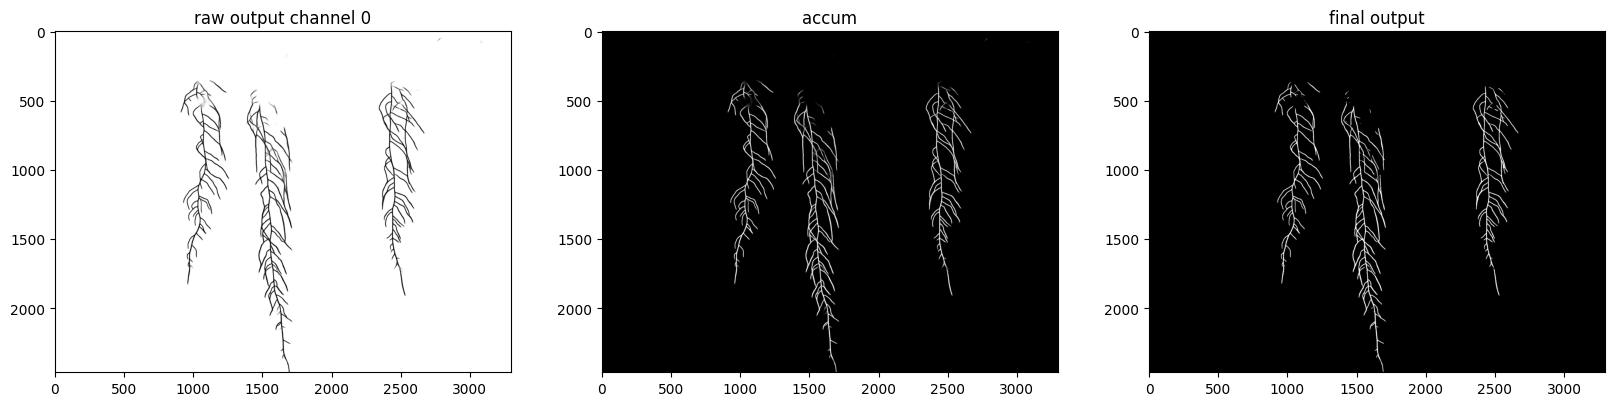

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.title("raw output channel 0")
plt.imshow(prediction[0,...,0], cmap="gray")

plt.subplot(1,3,2)
plt.title("accum")
plt.imshow(accum, cmap="gray")

plt.subplot(1,3,3)
plt.title("final output")
plt.imshow(outimg, cmap="gray")

True

In [ ]:
https://github.com/ngaggion/ChronoRoot/blob/master/segmentFast.py

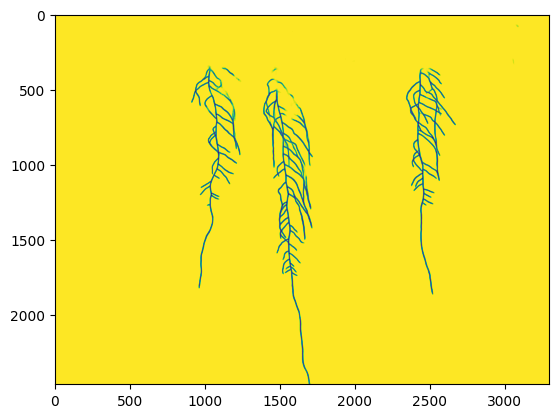

In [ ]:
plt.imshow(prediction[0,...,0])

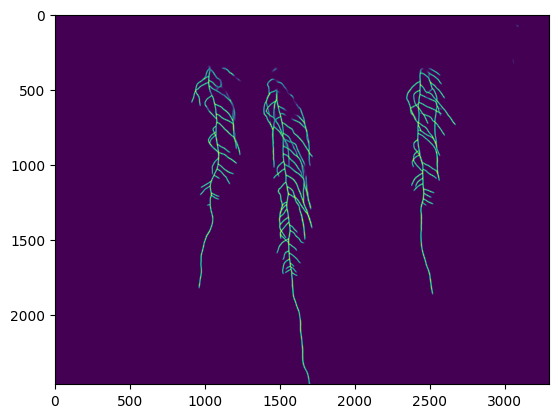

In [ ]:
plt.imshow(prediction[0,...,1])

In [ ]:
# post process with crf


1